## ML Project: Delayed Flights
A classification problem involving whether a flight will be delayed based on past data about:
- year of flight
- carrier
- airport
- weather patterns
- number of other cancelled flights
- and more!

In [1]:
from __future__ import print_function
from packaging.version import parse as Version
from platform import python_version

OK = '\x1b[42m[ OK ]\x1b[0m'
FAIL = "\x1b[41m[FAIL]\x1b[0m"

try:
    import importlib
except ImportError:
    print(FAIL, "Python version 3.10 is required,"
                " but %s is installed." % sys.version)

def import_version(pkg, min_ver, fail_msg=""):
    mod = None
    try:
        mod = importlib.import_module(pkg)
        if pkg in {'PIL'}:
            ver = mod.VERSION
        else:
            ver = mod.__version__
        if Version(ver) == Version(min_ver):
            print(OK, "%s version %s is installed."
                  % (lib, min_ver))
        else:
            print(FAIL, "%s version %s is required, but %s installed."
                  % (lib, min_ver, ver))    
    except ImportError:
        print(FAIL, '%s not installed. %s' % (pkg, fail_msg))
    return mod

# first check the python version
pyversion = Version(python_version())

if pyversion >= Version("3.11.4"):
    print(OK, "Python version is %s" % pyversion)
elif pyversion < Version("3.11"):
    print(FAIL, "Python version 3.11 is required,"
                " but %s is installed." % pyversion)
else:
    print(FAIL, "Unknown Python version: %s" % pyversion)

    
print()
requirements = {'numpy': "1.24.4", 'matplotlib': "3.7.2",'sklearn': "1.3.0", 
                'pandas': "2.0.3",'xgboost': "1.7.6", 'shap': "0.42.1", 'seaborn': "0.12.2"}

# now the dependencies
for lib, required_version in list(requirements.items()):
    import_version(lib, required_version)

[ OK ] Python version is 3.11.4

[ OK ] numpy version 1.24.4 is installed.
[ OK ] matplotlib version 3.7.2 is installed.
[ OK ] sklearn version 1.3.0 is installed.
[ OK ] pandas version 2.0.3 is installed.
[ OK ] xgboost version 1.7.6 is installed.


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


[ OK ] shap version 0.42.1 is installed.
[ OK ] seaborn version 0.12.2 is installed.


## Step 1: Exploratory Data Analysis
The dataset I will be working on is the kaggle January Flight Delay dataset. I will perform the first step of the ML pipeline, EDA, on this dataset.

For reference, a link to a description of the dataset is linked here: [https://docs.google.com/document/d/1FP7WVHgmvOfypMkYMs-HZo1liRk3u3YqpVW4JHm8Bj8/edit?usp=sharing] , but can also be found as a txt file in the data folder of this project repository.

First, reading it in and creating easier columns:

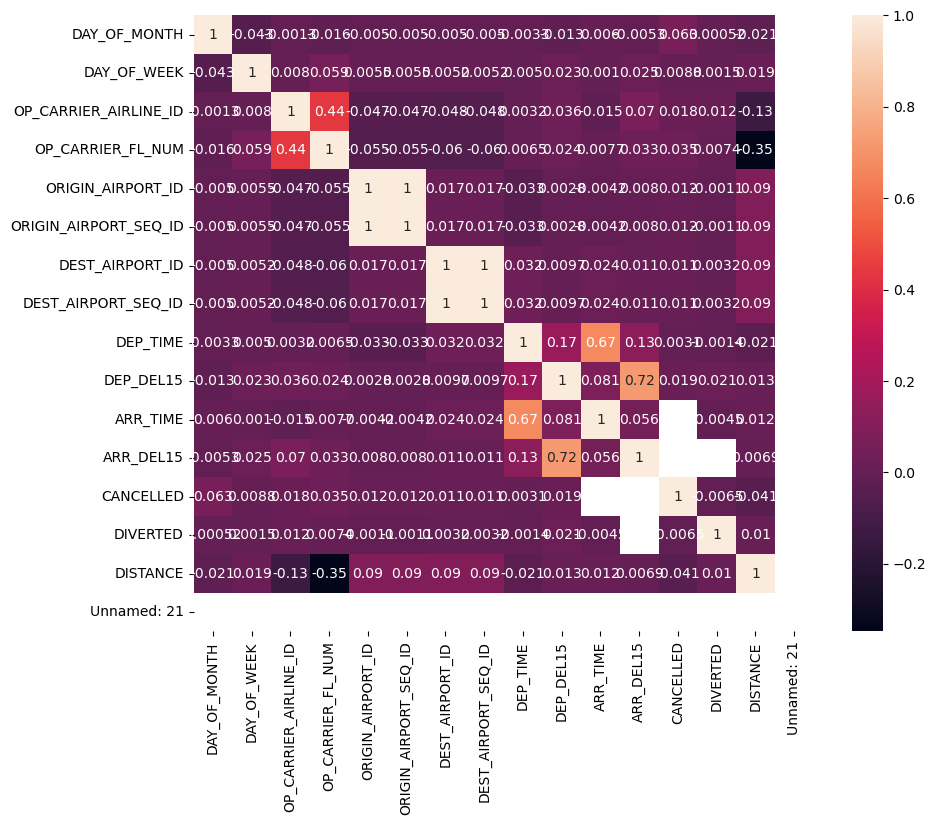

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pylab as plt
#Read files in:
df19 = pd.read_csv('data/archive/Jan_2019_ontime.csv')
df20 = pd.read_csv('data/archive/Jan_2020_ontime.csv')
temp_df_corr = pd.concat([df19, df20], ignore_index=True)

#Make columns easier:
df19 = df19.rename(columns={'DAY_OF_MONTH': 'DATE'})
df20 = df20.rename(columns={'DAY_OF_MONTH': 'DATE'})

df19['DATE'] = pd.to_datetime('2019-01-' + df19['DATE'].apply(str))
df20['DATE'] = pd.to_datetime('2020-01-' + df20['DATE'].apply(str))

df19['DAY_OF_WEEK']=df19['DATE'].dt.day_name()
df20['DAY_OF_WEEK']=df20['DATE'].dt.day_name()


df19.head(10)

#make pearson heat map with numeric data:
import seaborn as sns
# Select only numeric columns for correlation
numeric_cols = temp_df_corr.select_dtypes(include=[np.number])

# Create the correlation matrix
corr = numeric_cols.corr()

# Create a heatmap
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, annot = True, xticklabels=corr.columns.values, yticklabels=corr.columns.values)

plt.show()

Now that it's cleaner, I will perform non-visual EDA tasks:

In [3]:
print(df19.dtypes) 


DATE                     datetime64[ns]
DAY_OF_WEEK                      object
OP_UNIQUE_CARRIER                object
OP_CARRIER_AIRLINE_ID             int64
OP_CARRIER                       object
TAIL_NUM                         object
OP_CARRIER_FL_NUM                 int64
ORIGIN_AIRPORT_ID                 int64
ORIGIN_AIRPORT_SEQ_ID             int64
ORIGIN                           object
DEST_AIRPORT_ID                   int64
DEST_AIRPORT_SEQ_ID               int64
DEST                             object
DEP_TIME                        float64
DEP_DEL15                       float64
DEP_TIME_BLK                     object
ARR_TIME                        float64
ARR_DEL15                       float64
CANCELLED                       float64
DIVERTED                        float64
DISTANCE                        float64
Unnamed: 21                     float64
dtype: object


I've decided to concatenate both dataframes, because my strategy is to use group-based k-fold. Specifically, I will do group-based k-fold cross-validation and time-based splitting, meaning that I will group the data by airport and use 2019 and 2020 data for training and testing separately. 

In [4]:
flight_df = pd.concat([df19, df20], ignore_index=True)
flight_df.head()
#flight_df.tail()

,DATE,DAY_OF_WEEK,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN,...,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,ARR_DEL15,CANCELLED,DIVERTED,DISTANCE,Unnamed: 21
0,2019-01-01,Tuesday,9E,20363,9E,N8688C,3280,11953,1195302,GNV,...,ATL,601.0,0.0,0600-0659,722.0,0.0,0.0,0.0,300.0,NaN
1,2019-01-01,Tuesday,9E,20363,9E,N348PQ,3281,13487,1348702,MSP,...,CVG,1359.0,0.0,1400-1459,1633.0,0.0,0.0,0.0,596.0,NaN
2,2019-01-01,Tuesday,9E,20363,9E,N8896A,3282,11433,1143302,DTW,...,CVG,1215.0,0.0,1200-1259,1329.0,0.0,0.0,0.0,229.0,NaN
3,2019-01-01,Tuesday,9E,20363,9E,N8886A,3283,15249,1524906,TLH,...,ATL,1521.0,0.0,1500-1559,1625.0,0.0,0.0,0.0,223.0,NaN
4,2019-01-01,Tuesday,9E,20363,9E,N8974C,3284,10397,1039707,ATL,...,FSM,1847.0,0.0,1900-1959,1940.0,0.0,0.0,0.0,579.0,NaN


Now let's understand and visualize the key features

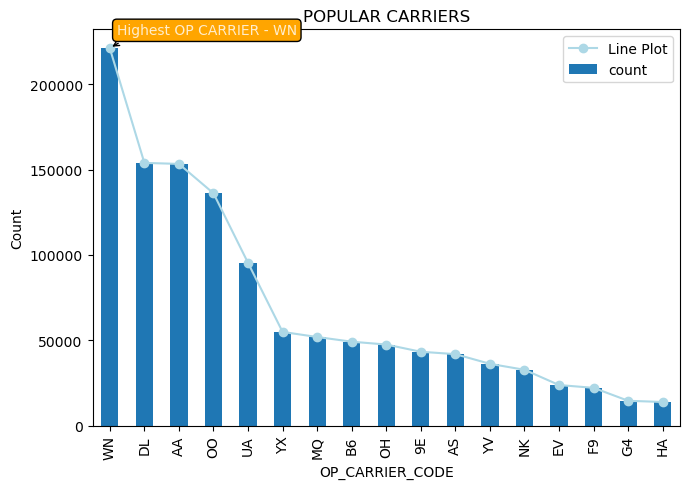

In [5]:
import matplotlib
from matplotlib import pylab as plt


#OP_CARRIER_19:
plt.figure(figsize=(7, 5))
flight_df['OP_CARRIER'] = flight_df['OP_CARRIER'].astype('category')

# Create a bar plot
carrier_counts = pd.value_counts(flight_df['OP_CARRIER'])
ax = carrier_counts.plot.bar()
plt.ylabel('Count')
plt.xlabel('OP_CARRIER_CODE')
plt.title('POPULAR CARRIERS')

# Add an annotation for the 'WN' bar
wn_count = carrier_counts['WN']
wn_index = carrier_counts.index.get_loc('WN')
plt.annotate("Highest OP CARRIER - WN", xy=(wn_index, wn_count), xytext=(5, 10),
             textcoords='offset points',
             arrowprops=dict(arrowstyle="->",
                             connectionstyle="arc3,rad=.2"),
             bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="orange"),
             fontsize=10, color="white", alpha=0.8)
plt.plot(carrier_counts.index, carrier_counts.values, marker='o', linestyle='-', color='lightblue', label='Line Plot')
plt.legend()

plt.tight_layout()
plt.show()




popular airports:

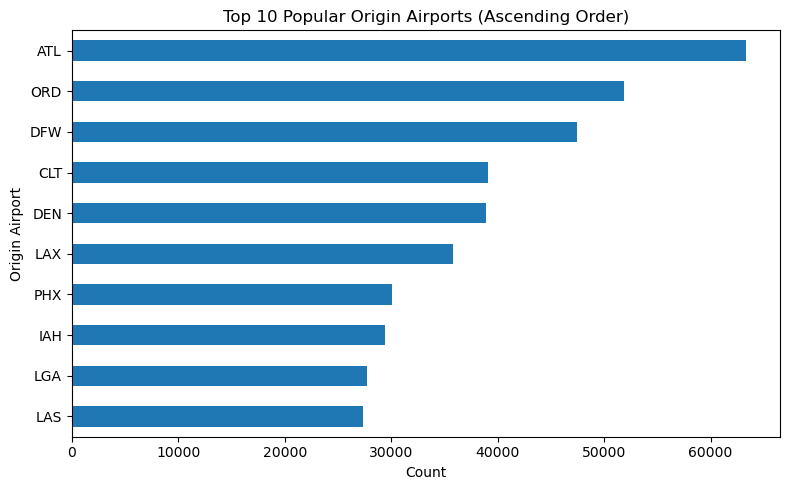

In [6]:

plt.figure(figsize=(8, 5))  

df_Org = flight_df['ORIGIN'].value_counts().head(10)

# Sort values in ascending order
df_Org = df_Org.sort_values(ascending=True)

# Create the horizontal bar chart
df_Org.plot(kind='barh')

plt.xlabel('Count')
plt.ylabel('Origin Airport')
plt.title('Top 10 Popular Origin Airports (Ascending Order)')
plt.tight_layout()
plt.show()

pie chart to visualize the distances of flights!:

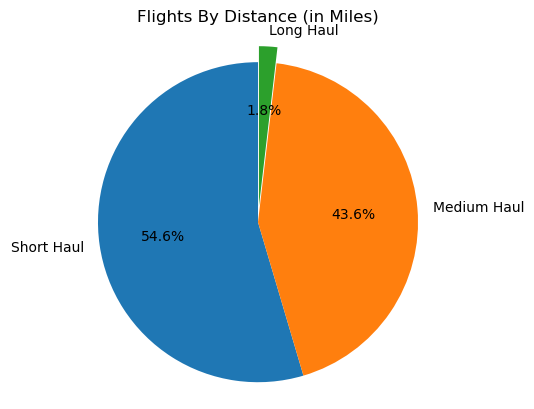

In [7]:

# Define the distance categories
short_haul = flight_df[(flight_df['DISTANCE'] < 700)].count()[0]
medium_haul = flight_df[(flight_df['DISTANCE'] >= 700) & (flight_df['DISTANCE'] <= 2500)].count()[0]
long_haul = flight_df[(flight_df['DISTANCE'] > 2500)].count()[0]

# Calculate the percentages
total_flights = len(flight_df)
short_haul_percentage = (short_haul / total_flights) * 100
medium_haul_percentage = (medium_haul / total_flights) * 100
long_haul_percentage = (long_haul / total_flights) * 100

# Mkae pie chart:
labels = ['Short Haul', 'Medium Haul', 'Long Haul']
sizes = [short_haul_percentage, medium_haul_percentage, long_haul_percentage]  # The sizes or percentages for each category


explode = (0, 0, 0.1)  # Explode the 1st slice (Short Haul)

# Create a pie chart
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, explode=explode)

# Add a title
plt.title('Flights By Distance (in Miles)')

# Display the pie chart
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

preprocess and split!:

In [8]:
flight_df.head()
#drop cols that will not be used:
flight_df = flight_df.drop(['OP_CARRIER', 'ORIGIN_AIRPORT_SEQ_ID', 'ARR_TIME', 'ARR_DEL15', 'ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_SEQ_ID', 'DEST_AIRPORT_ID', 'Unnamed: 21', 'CANCELLED', 'DIVERTED'], axis=1)


In [9]:
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import train_test_split
#set up groupkfold:
n_splits = 5
group_kfold = GroupKFold(n_splits=n_splits)

# Define the unique airports as groups
groups = flight_df['ORIGIN'].values

# Prepare features and target variable
y = flight_df['DEP_DEL15'] 
X = flight_df.loc[:, flight_df.columns != 'DEP_DEL15']
print('X shape:', X.shape)
print('y shape:', y.shape)

#I've decided not to use 60-20-20 split, as this gets rather impossible for my objective of using 2020 as testing and 2019 as training/val. 
#Instead, the ratios are more like 45-45-10
for train_idx, test_idx in group_kfold.split(X, y, groups):
    # Split the data into training and testing groups
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Time-based split within each group
    split_date = '2020-01-01'  
    train_mask = X_train['DATE'] < split_date
    test_mask = X_test['DATE'] >= split_date

    X_train, X_val = X_train[train_mask], X_train[~train_mask]
    y_train, y_val = y_train[train_mask], y_train[~train_mask]
    X_test = X_test[test_mask]
    y_test = y_test[test_mask]
    
print('X_test shape:', X_test.shape)
print('X_train shape:', X_train.shape)
print('X_val shape:', X_val.shape)


X shape: (1191331, 11)
y shape: (1191331,)
X_test shape: (121741, 11)
X_train shape: (467461, 11)
X_val shape: (485605, 11)


Preprocessing: Missing Values

In [10]:
print('data dimensions:',flight_df.shape)
perc_missing_per_ftr = flight_df.isnull().sum(axis=0)/flight_df.shape[0]
print('fraction of missing values in features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])
print('data types of the features with missing values:')
print(flight_df[perc_missing_per_ftr[perc_missing_per_ftr > 0].index].dtypes)
frac_missing = sum(flight_df.isnull().sum(axis=1)!=0)/flight_df.shape[0]
print('fraction of points with missing values:',frac_missing)


data dimensions: (1191331, 12)
fraction of missing values in features:
TAIL_NUM     0.002720
DEP_TIME     0.019320
DEP_DEL15    0.019351
dtype: float64
data types of the features with missing values:
TAIL_NUM      object
DEP_TIME     float64
DEP_DEL15    float64
dtype: object
fraction of points with missing values: 0.019351464874161756


One hot encoder for preprocessing Tail Nums. 
Explanation of TAIL_NUM -> A tail number is an alphanumeric code between two and six characters in length used to identify a specific airplane. The alphabetical prefix of a tail number is indicative of an airplane's country of origin

In [11]:
len(flight_df['TAIL_NUM'].unique())

5858

In [12]:
#sanity check: actually checking that these columns are actually missing
rows_with_missing_values_tail = flight_df[flight_df['TAIL_NUM'].isna()]
rows_with_missing_values_tail.head()
#rows_with_missing_values_DEPDEL15 = flight_df[flight_df['DEP_DEL15'].isna()]
#rows_with_missing_values_DEPDEL15.head()

,DATE,DAY_OF_WEEK,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,DISTANCE
11084,2019-01-01,Tuesday,YV,20378,NaN,5975,FSD,DFW,NaN,NaN,0700-0759,737.0
17776,2019-01-01,Tuesday,YV,20378,NaN,5758,ABQ,PHX,NaN,NaN,0800-0859,328.0
53853,2019-01-03,Thursday,YX,20452,NaN,4629,OKC,PHL,NaN,NaN,0001-0559,1261.0
56065,2019-01-03,Thursday,YV,20378,NaN,5909,MOB,DFW,NaN,NaN,0600-0659,539.0
64336,2019-01-04,Friday,WN,19393,NaN,955,OKC,DCA,NaN,NaN,0700-0759,1158.0


In [ ]:
#imports:
# preprocess with pipeline and columntransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

random_state = 42

#categorical vs numerical (no real nominals)
cat_ftrs = ['DAY_OF_WEEK', 'OP_UNIQUE_CARRIER', 'TAIL_NUM', 'ORIGIN', 'DEST', 'DEP_TIME_BLK']
num_ftrs = ['DEP_TIME', 'DISTANCE']

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant',fill_value='missing')), #Simple Imputer replaces NaN with string 'missing'.
    ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])  # 'missing' values will be removed.

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_ftrs),
        ('cat', categorical_transformer, cat_ftrs)])


#######
X_prep = preprocessor.fit_transform(X_train)
#feature_names = preprocessor.get_feature_names_out()
feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names(cat_ftrs + num_ftrs)

#CV:
X_val = preprocessor.transform(X_val)
X_val = pd.DataFrame(data=X_val,columns = feature_names)
print(X_val.shape)

# transform the test
X_test = preprocessor.transform(X_test)
X_test = pd.DataFrame(data=X_test,columns = feature_names)
print(X_test.shape)

print(feature_names)


# model_pipeline = Pipeline([
#     ('preprocessor', preprocessor),
#     ('classifier', YourModelHere())  # Replace with your chosen classifier
# ])

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
